In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
from matplotlib import pyplot
from sklearn import  metrics, model_selection

In [3]:
data = pd.read_csv('cleaned_data.csv')

In [4]:
data

,Unnamed: 0,funded_amnt_inv,int_rate,installment,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,last_pymnt_amnt,open_rv_12m,inq_last_12m,mths_since_recent_inq,sub_grade_num,target
0,0,10000.0,20.89,376.19,1234.97,1234.97,317.06,0.0,376.19,5.0,1.0,4.000000,17,0
1,1,7000.0,10.33,226.96,447.89,447.89,113.05,0.0,226.96,1.0,0.0,7.103784,30,0
2,2,23000.0,11.31,756.38,741.93,741.93,202.32,0.0,763.61,0.0,7.0,8.000000,28,0
3,3,4000.0,7.02,123.55,244.76,244.76,43.87,0.0,123.55,0.0,0.0,19.000000,34,0
4,4,24000.0,16.14,585.43,563.91,563.91,301.28,0.0,596.19,3.0,1.0,8.000000,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,10000.0,15.05,238.17,3149.68,3149.68,1366.73,0.0,238.17,2.0,2.0,1.000000,22,0
14996,14996,14750.0,7.21,464.60,8427.59,8287.13,1132.59,0.0,464.60,0.0,2.0,1.000000,33,0
14997,14997,7000.0,9.44,224.04,3580.97,3580.97,711.88,0.0,224.04,0.0,1.0,5.000000,30,0
14998,14998,8025.0,15.05,287.06,4615.19,4475.76,1402.09,0.0,287.06,4.0,6.0,7.000000,22,0


In [5]:
data = data.iloc[:,1:]

<AxesSubplot:>

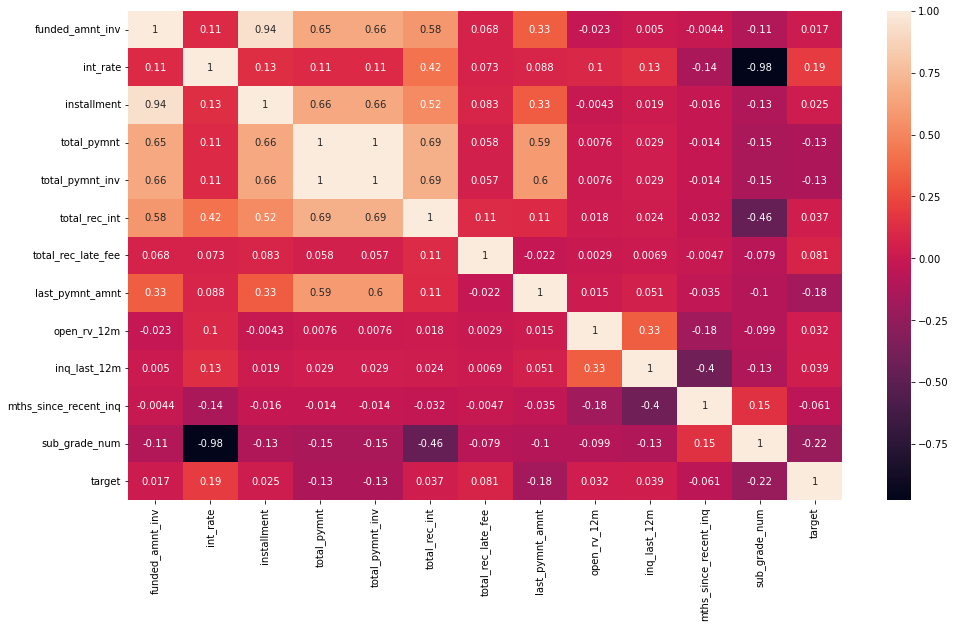

In [6]:
plt.figure(figsize=(16, 9))
sns.heatmap(data.corr(), annot=True)

array([[<AxesSubplot:xlabel='funded_amnt_inv', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='int_rate', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='installment', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='total_pymnt', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='total_pymnt_inv', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='total_rec_int', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='total_rec_late_fee', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='last_pymnt_amnt', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='open_rv_12m', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='inq_last_12m', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='mths_since_recent_inq', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='sub_grade_num', ylabel='funded_amnt_inv'>,
        <AxesSubplot:xlabel='target', ylabel='funded_amnt_inv'>],
       [<AxesSubplot:xlabel='funded_amnt_inv', ylabel='int_rate

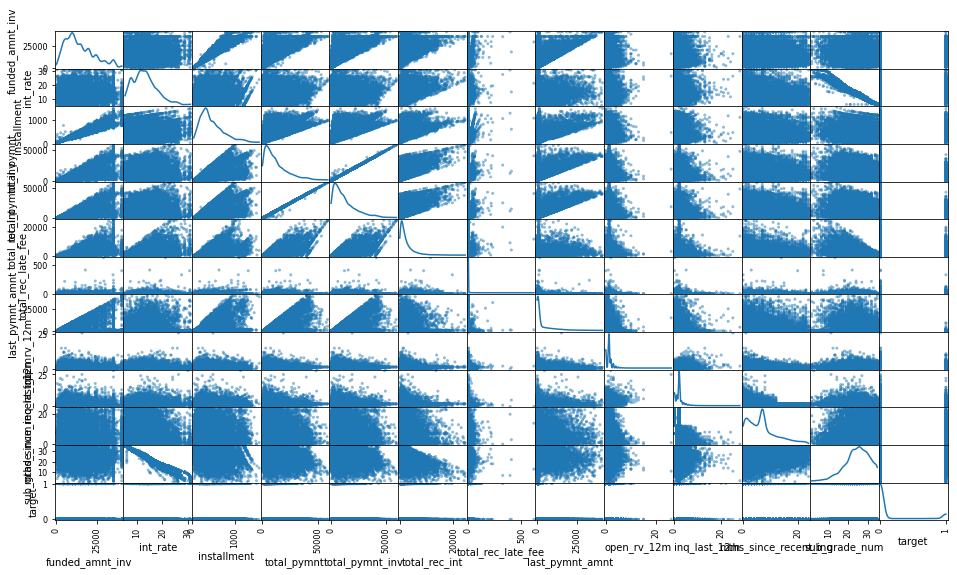

In [7]:
pd.plotting.scatter_matrix(data, alpha=0.5, figsize=(16, 9), diagonal='kde')

In [8]:
#try to remove multicollinearity, scale data for logistic regression

In [9]:
lr_data = data.drop(["total_pymnt_inv"], axis=1)

In [10]:
from sklearn.preprocessing import StandardScaler
#scale data as I will also be tunning l2 regularisation, 

In [11]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(lr_data.iloc[:,:-1]), columns = lr_data.iloc[:,:-1].columns)

In [12]:
#logistic regression

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score
x_train,x_test,y_train,y_test = train_test_split(scaled_data #lr_data.iloc[:,:-1]
                                                 , lr_data["target"] ,test_size=0.2, random_state= 44)

In [14]:
sum(y_train)/len(y_train), sum(y_test)/len(y_test)

(0.1155, 0.11466666666666667)

In [15]:
from numpy import mean
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

In [16]:
#other than normal tunning, I also tune class weight to combat the imbalance in 0s and 1s
# will lay off l1 as I have removed many features from previous steps

In [17]:
model = LogisticRegression( max_iter = 1000)


parameters = {
    'penalty' : ['l2'], 
    'C'       : [0.1, 1 ,10, 100],
    'solver'  : ['lbfgs', 'liblinear'],
    "class_weight" : [{0:1,1:1}, {0:1,1:5}, {0:1,1:len(data)/sum(data["target"])}, {0:1,1:10} ]
}

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=1)

grid = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=-1, cv=cv, scoring='roc_auc')

grid_result = grid.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.851395 using {'C': 100, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.840231 (0.011862) with: {'C': 0.1, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.838593 (0.012007) with: {'C': 0.1, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'liblinear'}
0.847029 (0.011808) with: {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.846462 (0.011841) with: {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'liblinear'}
0.847756 (0.011728) with: {'C': 0.1, 'class_weight': {0: 1, 1: 8.670520231213873}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.847373 (0.011750) with: {'C': 0.1, 'class_weight': {0: 1, 1: 8.670520231213873}, 'penalty': 'l2', 'solver': 'liblinear'}
0.847839 (0.011700) with: {'C': 0.1, 'class_weight': {0: 1, 1: 10}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.847499 (0.011718) with: {'C': 0.1, 'class_weight': {0: 1, 1: 10}, 'penalty': 'l2', 'solver': 'liblinear'}
0.848540 (0.011954) with: {'

precision: 0.3260647359454855
accuracy: 0.7994166666666667
f1_socre: 0.44295302013422816
recall: 0.6904761904761905
[[8636 1978]
 [ 429  957]]
precision: 0.3333333333333333
accuracy: 0.8033333333333333
f1_socre: 0.45471349353049906
recall: 0.7151162790697675
[[2164  492]
 [  98  246]]


C:\Users\docto\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


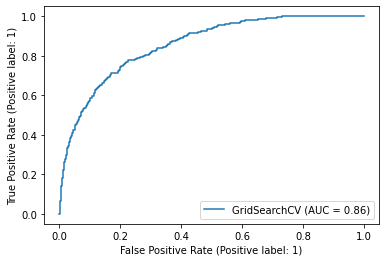

In [18]:
y_pred_train = grid_result.predict(x_train)


print("precision: {}".format(precision_score(y_train, y_pred_train)))
print("accuracy: {}".format(accuracy_score(y_train, y_pred_train)))
print("f1_socre: {}".format(f1_score(y_train, y_pred_train)))
print("recall: {}".format(recall_score(y_train, y_pred_train)))
print(confusion_matrix(y_train, y_pred_train))

y_pred_test = grid_result.predict(x_test)

print("precision: {}".format(precision_score(y_test, y_pred_test)))
print("accuracy: {}".format(accuracy_score(y_test, y_pred_test)))
print("f1_socre: {}".format(f1_score(y_test, y_pred_test)))
print("recall: {}".format(recall_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))

metrics.plot_roc_curve(grid_result, x_test, y_test)

precision: 0.3333333333333333
accuracy: 0.8033333333333333
f1_socre: 0.45471349353049906
recall: 0.7151162790697675
[[2164  492]
 [  98  246]]


C:\Users\docto\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


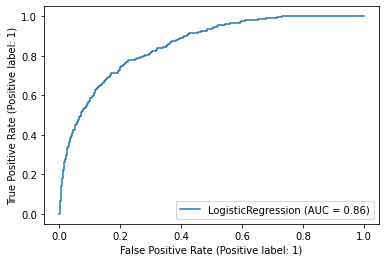

In [19]:
model = LogisticRegression(solver = 'lbfgs', C = 100, penalty = "l2", class_weight = {0:1,1:5})
model.fit(x_train, y_train)

y_pred_test = model.predict(x_test)
print("precision: {}".format(precision_score(y_test, y_pred_test)))
print("accuracy: {}".format(accuracy_score(y_test, y_pred_test)))
print("f1_socre: {}".format(f1_score(y_test, y_pred_test)))
print("recall: {}".format(recall_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))

metrics.plot_roc_curve(model, x_test, y_test)

In [20]:
import shap
explainer = shap.Explainer(model, x_train, feature_names=x_train.columns)
shap_values = explainer(x_test)

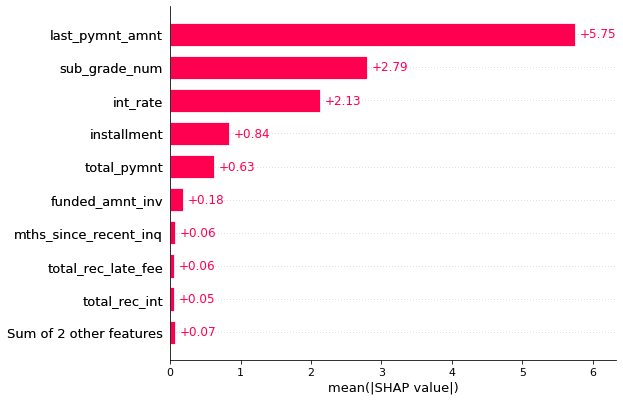

In [21]:
shap.plots.bar(shap_values)

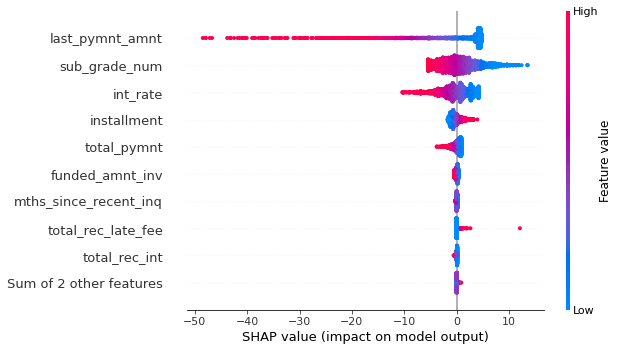

In [22]:
shap.plots.beeswarm(shap_values)

In [23]:
data

,funded_amnt_inv,int_rate,installment,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,last_pymnt_amnt,open_rv_12m,inq_last_12m,mths_since_recent_inq,sub_grade_num,target
0,10000.0,20.89,376.19,1234.97,1234.97,317.06,0.0,376.19,5.0,1.0,4.000000,17,0
1,7000.0,10.33,226.96,447.89,447.89,113.05,0.0,226.96,1.0,0.0,7.103784,30,0
2,23000.0,11.31,756.38,741.93,741.93,202.32,0.0,763.61,0.0,7.0,8.000000,28,0
3,4000.0,7.02,123.55,244.76,244.76,43.87,0.0,123.55,0.0,0.0,19.000000,34,0
4,24000.0,16.14,585.43,563.91,563.91,301.28,0.0,596.19,3.0,1.0,8.000000,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,10000.0,15.05,238.17,3149.68,3149.68,1366.73,0.0,238.17,2.0,2.0,1.000000,22,0
14996,14750.0,7.21,464.60,8427.59,8287.13,1132.59,0.0,464.60,0.0,2.0,1.000000,33,0
14997,7000.0,9.44,224.04,3580.97,3580.97,711.88,0.0,224.04,0.0,1.0,5.000000,30,0
14998,8025.0,15.05,287.06,4615.19,4475.76,1402.09,0.0,287.06,4.0,6.0,7.000000,22,0


In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
x_train,x_test,y_train,y_test = train_test_split(data.iloc[:,:-1], data["target"] ,test_size=0.2, random_state= 44)

In [26]:
model = DecisionTreeClassifier()

parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : list(range(1,15)),
    "class_weight" : [{0:1,1:1}, {0:1,1:5}, {0:1,1:len(data)/sum(data["target"])}, {0:1,1:10} ],
    "min_samples_leaf": [1,10,50,100,200],
    "max_features" : ["log2", "sqrt"],
}

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.853884 using {'class_weight': {0: 1, 1: 10}, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 50}
0.619991 (0.048108) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1}
0.626075 (0.040921) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 10}
0.615934 (0.054398) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 50}
0.629632 (0.046127) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 100}
0.631970 (0.039302) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 200}
0.612266 (0.055174) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1}
0.6346

precision: 0.3147917186330756
accuracy: 0.76075
f1_socre: 0.467840593141798
recall: 0.9105339105339105
[[7867 2747]
 [ 124 1262]]
precision: 0.26953125
accuracy: 0.728
f1_socre: 0.4035087719298245
recall: 0.8023255813953488
[[1908  748]
 [  68  276]]


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


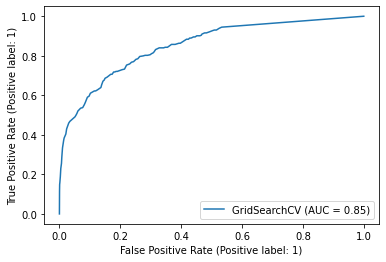

In [27]:
y_pred_train = grid_result.predict(x_train)

print("precision: {}".format(precision_score(y_train, y_pred_train)))
print("accuracy: {}".format(accuracy_score(y_train, y_pred_train)))
print("f1_socre: {}".format(f1_score(y_train, y_pred_train)))
print("recall: {}".format(recall_score(y_train, y_pred_train)))
print(confusion_matrix(y_train, y_pred_train))

y_pred_test = grid_result.predict(x_test)

print("precision: {}".format(precision_score(y_test, y_pred_test)))
print("accuracy: {}".format(accuracy_score(y_test, y_pred_test)))
print("f1_socre: {}".format(f1_score(y_test, y_pred_test)))
print("recall: {}".format(recall_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))
metrics.plot_roc_curve(grid_result, x_test, y_test)

In [28]:
grid_result.best_params_

{'class_weight': {0: 1, 1: 10},
 'criterion': 'entropy',
 'max_depth': 14,
 'max_features': 'log2',
 'min_samples_leaf': 50}

In [29]:
model = DecisionTreeClassifier( class_weight = {0: 1, 1: 10}, criterion = 'entropy', max_depth = 13, max_features = 'sqrt'
                              ,min_samples_leaf = 50)
model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, criterion='entropy',
                       max_depth=13, max_features='sqrt', min_samples_leaf=50)

precision: 0.2556179775280899
accuracy: 0.7113333333333334
f1_socre: 0.386685552407932
recall: 0.7936046511627907
[[1861  795]
 [  71  273]]


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


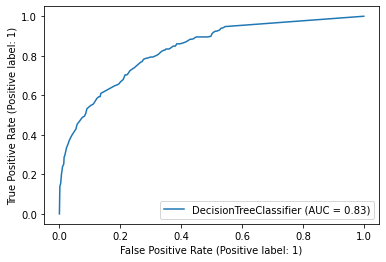

In [31]:
y_pred_test = model.predict(x_test)
print("precision: {}".format(precision_score(y_test, y_pred_test)))
print("accuracy: {}".format(accuracy_score(y_test, y_pred_test)))
print("f1_socre: {}".format(f1_score(y_test, y_pred_test)))
print("recall: {}".format(recall_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))

metrics.plot_roc_curve(model, x_test, y_test)

In [32]:
from sklearn import tree

[Text(0.794016768292683, 0.9642857142857143, 'X[3] <= 22379.115\nentropy = 0.987\nsamples = 12000\nvalue = [10614, 13860]'),
 Text(0.655977787456446, 0.8928571428571429, 'X[2] <= 632.935\nentropy = 0.971\nsamples = 10243\nvalue = [8904, 13390]'),
 Text(0.5114329268292683, 0.8214285714285714, 'X[4] <= 11093.04\nentropy = 0.987\nsamples = 9002\nvalue = [7958, 10440]'),
 Text(0.3634581881533101, 0.75, 'X[7] <= 938.045\nentropy = 0.955\nsamples = 6294\nvalue = [5399, 8950]'),
 Text(0.29834494773519166, 0.6785714285714286, 'X[9] <= 2.01\nentropy = 0.897\nsamples = 4966\nvalue = [4072, 8940]'),
 Text(0.18902439024390244, 0.6071428571428571, 'X[10] <= 15.5\nentropy = 0.999\nsamples = 2831\nvalue = [2559, 2720]'),
 Text(0.1132404181184669, 0.5357142857142857, 'X[11] <= 28.5\nentropy = 0.996\nsamples = 2383\nvalue = [2134, 2490]'),
 Text(0.05226480836236934, 0.4642857142857143, 'X[2] <= 75.565\nentropy = 0.962\nsamples = 1547\nvalue = [1334, 2130]'),
 Text(0.04529616724738676, 0.392857142857142

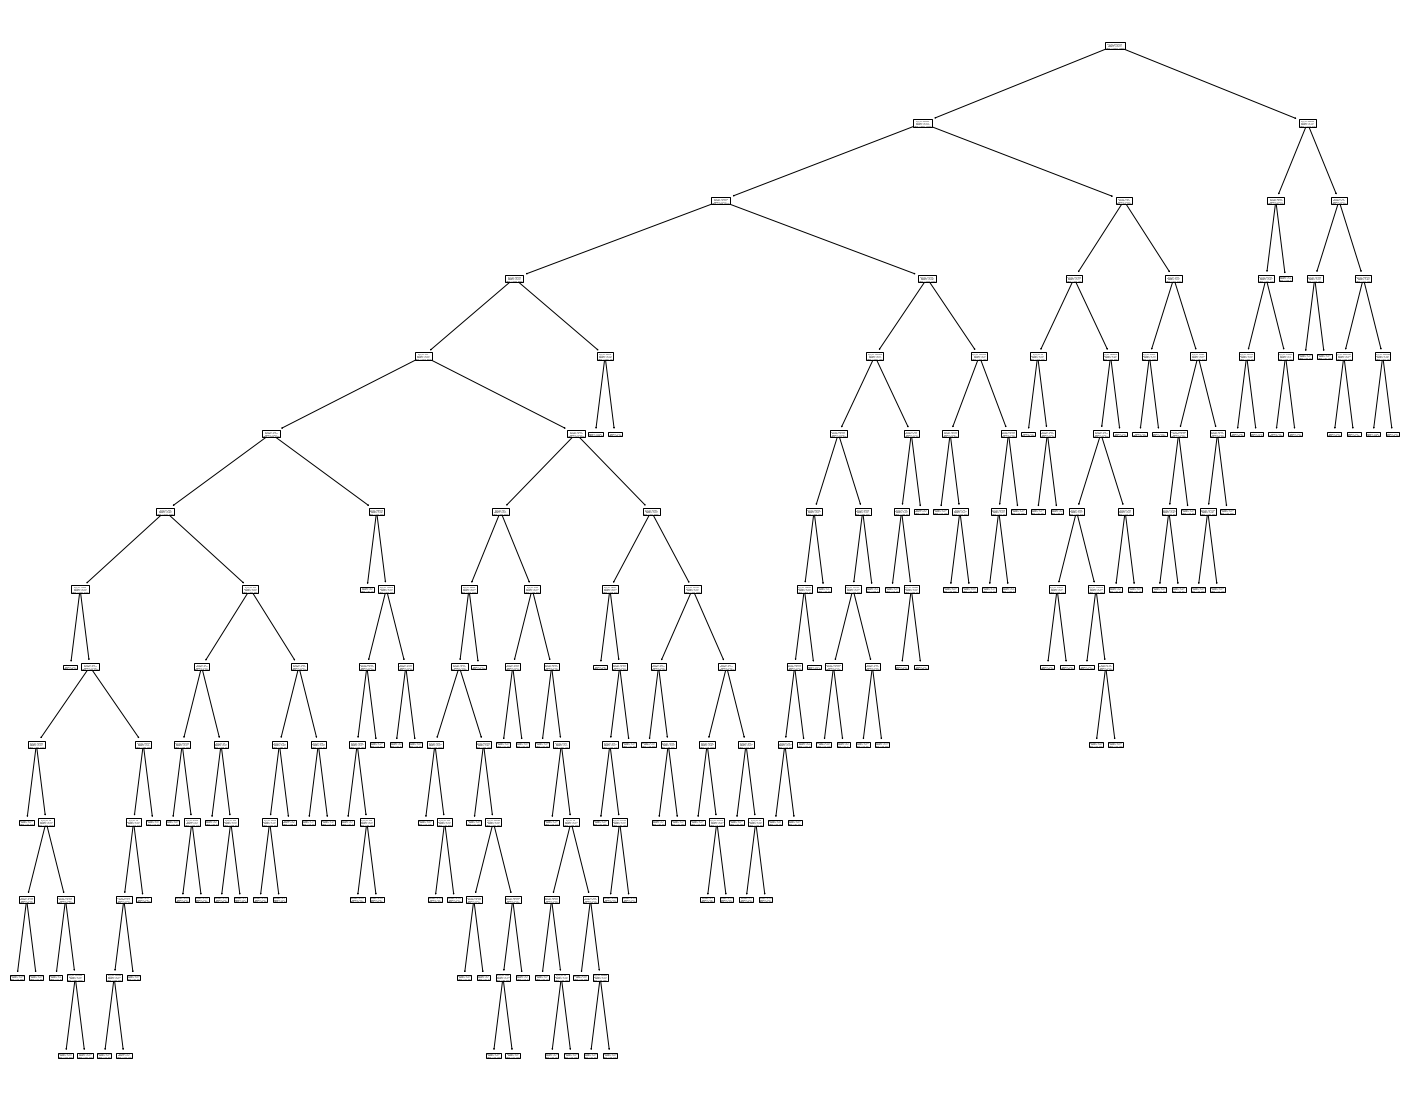

In [33]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(model)

In [38]:
importance = model.feature_importances_

feature_importance_sk = {}

for i, feature in enumerate(x_train.columns):
    feature_importance_sk[feature] = round(importance[i], 3)
    
feature_importance = pd.DataFrame(feature_importance_sk.items())

<function matplotlib.pyplot.show(close=None, block=None)>

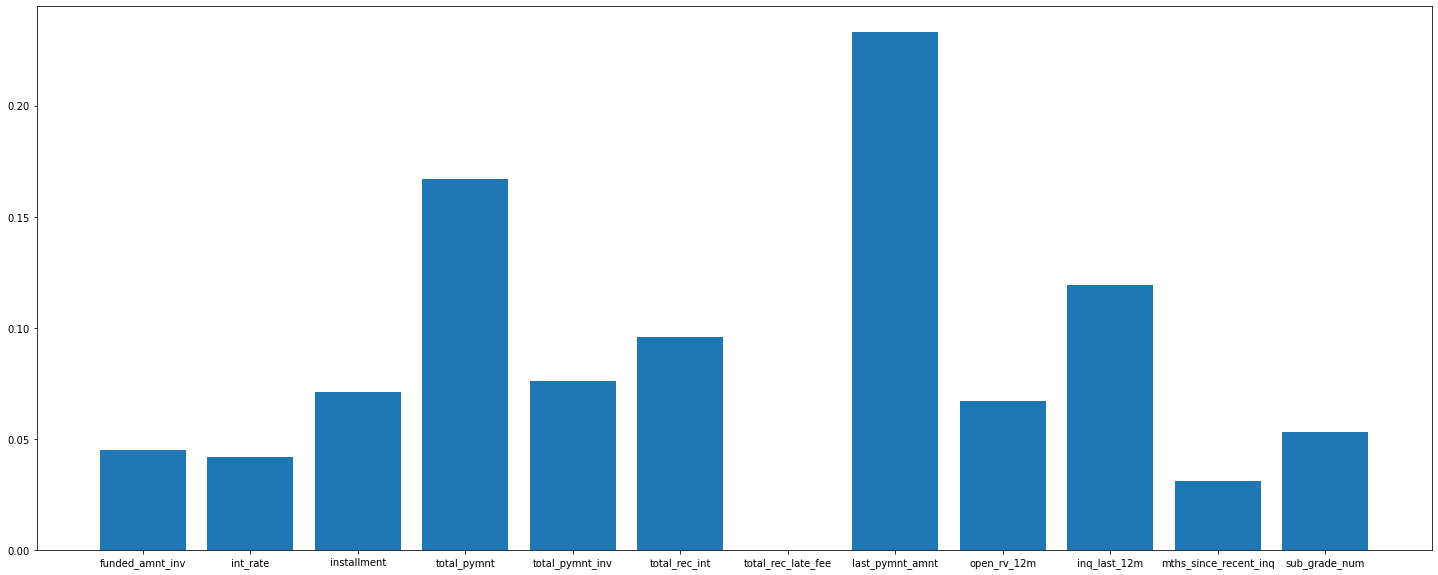

In [39]:
plt.figure(figsize=(25, 10))
plt.bar(feature_importance[0], feature_importance[1])
plt.show

In [40]:
#thought about PCA but I want to keep explanability
#outliers?
#feature engineering? some magical features
#average payment intervals? frequency of other payments?
#try other tree based models, rf, gradient boosting
#ensemble